In [1]:
from rxitect.structs.property import Property
from rxitect.models.vanilla.predictor import Predictor
from globals import root_path
from rdkit.Chem.QED import qed
from rxitect.structs import sa_scorer
from rdkit import Chem
from rxitect.structs.vocabulary import SelfiesVocabulary
import matplotlib.pyplot as plt
import seaborn as sns
from rxitect.models.vanilla.generator import VanillaGenerator
from rdkit.Chem import Draw
from typing import List

import torch
import selfies as sf
import numpy as np

In [2]:
p = Property()

In [3]:
mols=['O=C(C1=CC=CC=C1)N2CCCC3(CCN(C(=O)N4CCCN(C5CCC5)CC4)C3)C2',
 'CN1C(SCCCN2CCC3(CC3C4=CC=C(C(F)(F)F)C=C4)C2)=NN=C1C5=CC=CC(C(N)=O)=C5',
 'N#CC1=CC=C(CN2C=NC=C2CNC3CCN(C(=O)C4=CC=CN=C4N)C3=O)C=C1',
 'O=S(=O)(C1=CC=C(N2CCC2)C=C1)C3(F)CCN(CCC4=CC=C(F)C=C4F)CC3',
 'N#CC1=CC(N2CCN(CCN3CC4=CC=CC=C4C3)C2=O)=CC=C1F',
 'O=C1OCC2=CC(CCN3CCN(C(=O)CC4=CC=C(N5C=NN=N5)C=N4)CC3)=CC=C21',
 'CC1=CC(O)=C2C=CC(N)=NC2=N1',
 'CCCN1C(=O)[NH1]C=2[NH1]C(C3=CC=C(C=CC(=O)OC)C=C3)=NC=2C1=O',
 'CC(NC(=O)C1(N)CCN(C2=NC=NC=3[NH1]C=CC2=3)CC1)C4=CC=CC=C4',
 'O=C(NC1=NC(C2=CC=CC=C2)=NC3=NN(CC4=CC=CC=C4)C=C13)C5=CC=CC(Cl)=C5']

class SelfiesTensorHandler:
    def __init__(self, vocabulary: SelfiesVocabulary) -> None:
        self.voc = vocabulary
    
    def selfies_tensor_to_smiles(self, selfies_tensor: torch.Tensor) -> List[str]:
        """
        Accepts a list of SELFIES encoded in tensor form, and decodes them
        to a SMILES string representing a molecule.
        
        Args:
            selfies_tensor: A tensor containing encoded SELFIES.
        Returns:
            A decoded SMILES string representing a molecule.
        """
        dec_sampled = [self.voc.decode(x) for x in selfies_tensor]
        smiles = [sf.decoder(x) for x in dec_sampled]
        return smiles
    
    def draw_sampled_selfies(self, selfies_tensor: torch.Tensor) -> None:
        """
        Helper function that takes generated encoded SELFIES tensors,
        decodes them to SMILES and draws them on screen.
        """
        smiles = self.selfies_tensor_to_smiles(selfies_tensor)
        Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in np.random.choice(smiles, size=50)])

In [4]:
A1_pred = Predictor(path=root_path / "models/RF_REG_CHEMBL226.pkg")

In [5]:
x  = A1_pred.calc_fp(mols=mols)[0]

In [6]:
len(x)

2067

In [7]:
A1_pred.__call__([x])

array([4.09165])

In [8]:
A1_pred.__dict__

{'type': 'REG',
 'model': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)}

In [9]:
m = Chem.MolFromSmiles(mols[0])
sa_scorer.calculateScore(m)

3.335589845441116

In [10]:
y = [sa_scorer.calculateScore(Chem.MolFromSmiles(mol)) for mol in mols] 

In [11]:
y

[3.335589845441116,
 3.9774018271890714,
 3.1811772153169153,
 2.5869806261447863,
 2.488569797155968,
 2.7119782726741697,
 2.5898589807780574,
 2.7073346527934827,
 3.037191162934895,
 2.2712876016430723]

In [12]:
z = [qed(Chem.MolFromSmiles(mol)) for mol in mols]

In [13]:
z

[0.7319564982478798,
 0.33897935808092133,
 0.5806173578840808,
 0.6848893705221439,
 0.8518308477300273,
 0.5220918062947202,
 0.6311689478833458,
 0.5349566540178774,
 0.6584876554589922,
 0.39505761204230616]

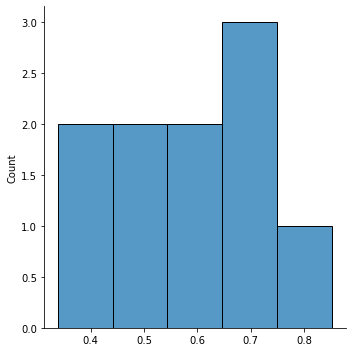

In [14]:
sns.displot(z)

In [15]:


voc = SelfiesVocabulary(vocabulary_file_path="../data/processed/selfies_voc.txt")
gen_RL = VanillaGenerator(voc=voc)
gen = VanillaGenerator(voc=voc)

gen_RL.load_state_dict(torch.load("../models/obj3_ra=xgb_dev.pkg"))
gen.load_state_dict(torch.load("../models/fine_tuned_selfies_rnn.ckpt")["state_dict"])

gen_RL.eval()
gen.eval()

handler = SelfiesTensorHandler(vocabulary=voc)

In [16]:
sample_RL = gen_RL.sample(1000)
mols_RL = handler.selfies_tensor_to_smiles(sample_RL)

In [17]:
qed_scores_RL = [qed(Chem.MolFromSmiles(mol)) for mol in mols_RL]

C:\Users\Julius\miniforge3\envs\rxitect\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

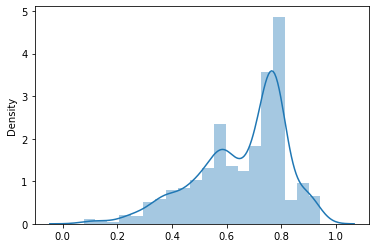

In [18]:
sns.distplot(qed_scores_RL)

In [19]:
sample_base = gen.sample(1000)
mols_base = handler.selfies_tensor_to_smiles(sample_base)

In [20]:
qed_scores_base = [qed(Chem.MolFromSmiles(mol)) for mol in mols_base]

C:\Users\Julius\miniforge3\envs\rxitect\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

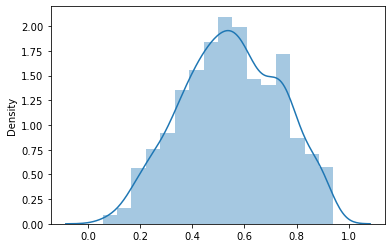

In [21]:
sns.distplot(qed_scores_base)

In [22]:
sa_scores_base = [sa_scorer.calculateScore(Chem.MolFromSmiles(mol)) for mol in mols_base]
sa_scores_RL = [sa_scorer.calculateScore(Chem.MolFromSmiles(mol)) for mol in mols_RL]

C:\Users\Julius\miniforge3\envs\rxitect\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

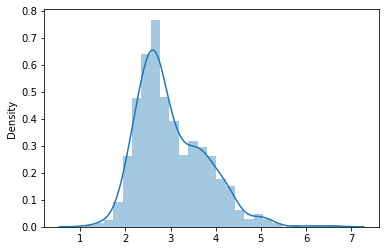

In [23]:
sns.distplot(sa_scores_base)

C:\Users\Julius\miniforge3\envs\rxitect\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

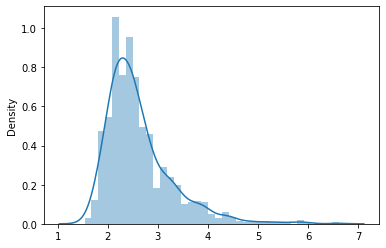

In [24]:
sns.distplot(sa_scores_RL)

In [26]:
mols_RL

['COC1=CC(C=CN(CC2=CC=C(C3=CC=CS3)C=C2)N=N)=CC=C1N4C=NC(C)=C4',
 'NC1=NC(C2=CC=CS2)=CN=CN(C3=CC=CO3)N=C1',
 'CCCN1C(=O)C=2N=C(C3CCC(CNCC4=NC=C[NH1]4)CC3)[NH1]C=2N(CCC)C1=O',
 'O=C(NC1=CC=C(C2=CC=NC=C2)C(C3=CC=CC=C3)=N1)C4CC4',
 'CNC1=NC=C(C(=O)OCC2=CC=CC=C2C)C3=NC(C4=CC=CO4)=NN13',
 'O=C(NC1=NC(C2=CC=C(F)C=C2)=NS1)N3CCC(C4=NC5=CC=CC=C5N4C6=CC=CC=C6C#N)CC3',
 'CC=C1C=CC(CNC(=O)NC2=NC(C=NC3=CC=CC=C3)=CS2)=C1',
 'CC1=CC=CC(C2=CC(C3=CC=CO3)=NC(N)=C2C)=NC1',
 'CC(=O)NC1=CC(C2=CC=CC=C2)=NC(C3=CC=CC=N3)=N1',
 'O=C(NC1=NC(C2=CC=CC=C2)=CC(C3=CC=CC=C3)=N1)C4CC4',
 'CCCOC(=O)C1=CN=C2C(C=NN2CC(Cl)C3=CC=CC=C3)=C1N4CCOCC4',
 'O=C(C1=CC=C(Cl)S1)NC2=NC(C3=CC=CO3)=NC4=CC=CC=C24',
 'CNC(=O)C1=CN=C(N)N2N=C(C3=CC=CO3)N=C12',
 'CN1C(=O)C2=CC=CC=C2C3=CC(C4=CC=CC=C4)=NN31',
 'C1C=CC=C(C(=O)NC2=NC(C3=CC=CS3)=NC4=CC=CC=C24)C1',
 'COCC1=CC(N)=NC(C2=CC=C(C=C3C=CN(C)N=C3NC)C2C)=C1',
 'NC1=NC=C(C2=CC=CC=C2)C(C3=CC=CC=C3)=N1',
 'CCCCC(=O)NC1=NC(C2=CC=CC=C2OC)=CC(C3=CC=C(F)C=C3)=N1',
 'O=C(NC1=NC(C2=CC=CC=C2)=CC(C3=